In [1]:
import src.arctic as arctic
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Data
- provided by the Institute of Atmospheric Physics Kühlungsborn (IAP)
- ERA5: daily means at pressure levels and analysis
    - Intercomparison with Hannachi et al. (2011)
    - SWE1.tar: contains major warming diagnostics
    - SWE1.tar: elliptic diagnostics of Z10
    - SWX1.tar: extended diagnostics (reachable via VPN)
    - SWC1.tar: classfiication synthesis (reachable via VPN)

#### File structure
netCDF files are 3-dimensional data, investigated with ncdump. The .tar-files contain all output from Christoph Zülickes diagnosis, in particular:
- SWM: ASCII values in 2 files, 
    1. *cen.csv with the major warming events as identified with their central day when the wind turned from westerly to easterly along with some characteristics and
    2. *msw.csv with daily lists with wind and a marker mw for major warming
- SWE: 1 csv file
    - *d.csv: daily list of indices, including the aspect ratio of the mother vortex (ar), centrail latitude (latcent) and area (area)

In [2]:
# Skips all lines starting with C
# Reads only lines starting with D
def read_data(input_file):
    with open(input_file, "r", encoding="utf-8") as f:
        filtered_lines = [line for line in f if line.startswith("D")]
    
    # Convert filtered lines into DataFrame
    from io import StringIO
    df = pd.read_csv(
        StringIO("".join(filtered_lines)),
        delimiter=",",
        low_memory=False
    )
    return df

era5_d = read_data("data/SWXClust/ERA5/e5e1_d.csv")
era5_cen = read_data("data/SWXClust/ERA5/e5m1t-cen.csv")
era5_msw = read_data("data/SWXClust/ERA5/e5m1t-msw.csv")

In [3]:
# delete space in front of strings
def no_white_space(df, sep = ' '):
    col = []
    for c in df.columns:
        col.append(c.split(sep)[-1])
    df.columns = col
    
# convert strings to actual dates
def to_date(df, col, format='mixed'):
    df[col] = pd.to_datetime(df[col], format=format)

# remove white space from column names
no_white_space(era5_d)
no_white_space(era5_cen)
no_white_space(era5_msw)

# change string to datetime for better comparison
to_date(era5_d, 'string')
to_date(era5_cen, 'string')
to_date(era5_msw, 'string')

era5_d.head()

,D,counter,time,string,year,month,day,hour,level,edge,...,obj_area2,latcent2,loncent2,theta2,ar2,amp0,amp1,amp2,lon1,lon2
0,D,1,2438031.25,1963-01-01 18:00:00,1963,1,1,18,10.0,29.2,...,,,,,,27.9,0.01040,0.0111,5.4,-2.5
1,D,2,2438032.25,1963-02-01 18:00:00,1963,1,2,18,10.0,29.2,...,,,,,,27.9,0.00858,0.0097,3.3,-2.3
2,D,3,2438033.25,1963-03-01 18:00:00,1963,1,3,18,10.0,29.2,...,,,,,,27.9,0.01120,0.0123,0.4,-2.7
3,D,4,2438034.25,1963-04-01 18:00:00,1963,1,4,18,10.0,29.2,...,,,,,,27.8,0.01190,0.0126,2.1,-2.5
4,D,5,2438035.25,1963-05-01 18:00:00,1963,1,5,18,10.0,29.2,...,,,,,,27.8,0.01080,0.0117,7.1,-2.5


In [4]:
# merge era5 data to one big dataframe
era5_all = era5_d.merge(era5_msw, on ='string', how='left', suffixes=[None, '_msw']).merge(era5_cen, on='string', how='left', suffixes = ['_d', '_cen'])

# handling string encodings
era5_all['form'] = era5_all['form'].replace({' D' : 0, ' S': 1})
# handling NaN values and string encodings
era5_all['MW'] = pd.to_numeric(era5_all.MW.replace({'   ': 0, ' MW' : 1}))
era5_all[era5_cen.columns[-4:]] = era5_all[era5_cen.columns[-4:]].fillna(0) 
era5_all.columns

Index(['D_d', 'counter_d', 'time_d', 'string', 'year', 'month', 'day', 'hour',
       'level', 'edge', 'form', 'area', 'obj_area', 'latcent', 'loncent',
       'theta', 'ar', 'kurtosis', 'area1', 'obj_area1', 'latcent1', 'loncent1',
       'theta1', 'ar1', 'area2', 'obj_area2', 'latcent2', 'loncent2', 'theta2',
       'ar2', 'amp0', 'amp1', 'amp2', 'lon1', 'lon2', 'D_msw', 'counter_msw',
       'time_msw', 'u', 'MW', 'D_cen', 'num', 'counter_cen', 'time_cen',
       'pers', 'Umax', 'Imax', 'Iacc'],
      dtype='object')

## Reconstruction of same conditions as Hannachi et al.
- time: winterperiod (december to march) from 1958 to 2002, activity peaks in dec - jan, oscilliation period around 120-130d
    - **Note**: only data after 1963 available 
- 7 stratospheeric variables:

| temp. (lat1) | temp (lat2) |temp. (lat3) | avg. zon. wind (lat1) | avg. zon. wind (lat2) | wave-1                    | wave-2                    |
|--------------|-------------|------------------|-----------------------|-----------------------|---------------------------|---------------------------|
| Zonally averaged | Zonally averaged | Zonally averaged | Zonally averaged <br/ | Zonally averaged      | Normalised by zonal winds | Normalised by zonal winds |
| 60-70°N      | 70-80°N     | 80-90°N          | 60-70°N               | 70-80°N               | 60°N                      | 60°N                      |

- 7 pressure levels between 100 to 1hPa
- geometrical features: latitude centroid (lat), area (area), aspect ratio (AR) - kurtosis omitted due to skewness

#### Approaches
1. Hierarchical Clustering
    - Used distance: Euclidean distance
    - Distance between Cluster: Complete Linkage to avoid chain and spheroidal tendencies of single and average linkage
    - Gap statistic to find number of clusters with Poisson point process (standard)
    - SSA to deal with seasonality and its variation

|               | between points in Cluster | Different                                  |
|---------------|---------------------------|--------------------------------------------|
| Closest       | Single Linkage            | Centroid Linkage                           |
| Most Distance | **Complete Linkage**      | Average Linkage (Average of all distances) |

In [5]:
# time constraints
era5_hannachi = era5_all[(era5_all['string'] < '01-01-2003') & 
                     (era5_all['month']).isin([12,1,2,3])]

era5_hannachi = era5_hannachi[['year', 'month', 'day', 'area', 'ar', 'latcent', 'kurtosis']]
# check for completeness
era5_hannachi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4850 entries, 0 to 14609
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      4850 non-null   int64  
 1   month     4850 non-null   int64  
 2   day       4850 non-null   int64  
 3   area      4850 non-null   float64
 4   ar        4850 non-null   float64
 5   latcent   4850 non-null   float64
 6   kurtosis  4850 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 303.1 KB


In [11]:
from sklearn.cluster import AgglomerativeClustering

In [12]:
def generate_reference_HPPP(X,
                            **kwargs):
    """
    Generate reference data as homogeneous poisson point process.

    Parameters:
    X: array-like, shape (n_samples, n_features)
        The input data.
    n_samples (optional): int
        Fixed number of samples to generate.
    lambda_ (optional): int
        Average number of samples to generate (point density).

    Returns:
    array-like: Randomly generated reference dataset.
    """
    n_samples = kwargs.get('n_samples', None)
    lambda_ = kwargs.get('lambda_', None)
    
    min_vals = X.min(axis=0)
    max_vals = X.max(axis=0)
    
    # Set intensity lambda (average number of points
    if n_samples is None:
        if lambda_ is None:
            lambda_ = len(X)
        n_samples = np.random.poisson(lambda_)
    
    return np.random.uniform(low=min_vals, high=max_vals, size=(n_samples, X.shape[1]))
 

In [13]:
from scipy.spatial.distance import pdist
def within_cluster_dispsersion(X, labels):
    """
    Compute the within-cluster dispersion (Wk) for hierarchical clustering.
    
    Parameters:
    X: array-like, shape (n_samples, n_featues)
        The input data.
    labels: array-like, shape (n_samples,)
        Cluster labels for each sample.

    Returns:
    float: The 
    """
    Wk = 0
    unique_clusters = np.unique(labels)
    
    for cluster in unique_clusters:
        cluster_points = X[labels == cluster]
        n_m = len(cluster_points)
        
        if n_m > 1:
            D_m = np.sum(pdist(cluster_points, metric='euclidean'))
            Wk += D_m/(2*n_m)
    return Wk

In [18]:

def compute_gap_statistic(X, k_max, n_replicates=10, **kwargs):
    n_samples = kwargs.get('n_samples', None)
    """
    Compute the Gap Statistic for a range of cluster numbers using Agglomerative Clustering.

    Parameters:
    X: array-like, shape (n_samples, n_features)
        The input data.
    k_max: int
        The maximum number of clusters to evaluate.
    n_replicates: int
        The number of bootstrap samples.

    Returns:
    gap_values: list
        The calculated gap values for each k.
    """
    gap_values = []
    
    for k in range(1, k_max + 1):
        # Fit Agglomerative Clustering to the original data
        clustering = AgglomerativeClustering(n_clusters=k, linkage='average')
        labels = clustering.fit_predict(X)
        original_Wk = within_cluster_dispsersion(X, labels)

        # Compute the reference dispersion values
        reference_Wk_values = []
        for _ in range(n_replicates):
            if n_samples:
                random_data = generate_reference_HPPP(X, n_samples=n_samples) # fixed sample size
            else:
                random_data = generate_reference_HPPP(X) # on average as many samples as in dataset
            clustering = AgglomerativeClustering(n_clusters=k, linkage='average')
            random_labels = clustering.fit_predict(random_data)
            reference_Wk_values.append(within_cluster_dispsersion(random_data, random_labels))

        # Compute log(Wk*) statistics
        log_Wk_star = np.log(reference_Wk_values)
        mean_log_Wk_star = np.mean(log_Wk_star)
        std_log_Wk_star = np.std(log_Wk_star)
        print("For k = ", k)
        print("Log(Wk*): ", log_Wk_star)
        print("Mean(log(Wk*)): ", mean_log_Wk_star)
        print("Log(Wk): ", np.log(original_Wk))
        
        # Compute inflated standard deviation
        s_k = std_log_Wk_star * np.sqrt(1 + (1 / n_replicates))

        # Compute Gap statistic
        gap = mean_log_Wk_star - np.log(original_Wk)
        gap_values.append((gap, s_k))

    return np.array(gap_values)

gap_values = compute_gap_statistic(era5_hannachi[['ar', 'latcent']], k_max=10)

For k =  1
Log(Wk*):  [9.52989759 9.56790477 9.53642938 9.53496335 9.5235875  9.52288937
 9.52469034 9.51849397 9.53622117 9.52296601]
Mean(log(Wk*)):  9.531804345031997
Log(Wk):  9.006698140144469
For k =  2
Log(Wk*):  [8.89712077 8.85357887 8.89281344 8.91771225 8.88300967 8.89144777
 8.95345494 8.94350488 8.98917569 8.87078898]
Mean(log(Wk*)):  8.909260726667242
Log(Wk):  8.85897907256356
For k =  3
Log(Wk*):  [8.53187059 8.56380079 8.52520384 8.53189172 8.53088581 8.60096601
 8.5453309  8.53678443 8.56471428 8.58188484]
Mean(log(Wk*)):  8.551333320273773
Log(Wk):  8.39397893922357
For k =  4
Log(Wk*):  [8.26252841 8.27592991 8.31816753 8.29915732 8.25953681 8.27599596
 8.28001054 8.27192838 8.25639325 8.30515191]
Mean(log(Wk*)):  8.280480002971869
Log(Wk):  8.389017182893385
For k =  5
Log(Wk*):  [8.1159712  8.1246099  8.17286926 8.15376861 8.08656587 8.15528383
 8.09502898 8.1123534  8.12866392 8.09008345]
Mean(log(Wk*)):  8.1235198426517
Log(Wk):  8.003972601085698
For k =  6
Log

In [19]:
for k in range(len(gap_values)-1):
    if gap_values[k, 0] >= gap_values[k+1, 0] - gap_values[k+1, 1]:
        print(k+1)
        break

1


<ErrorbarContainer object of 3 artists>

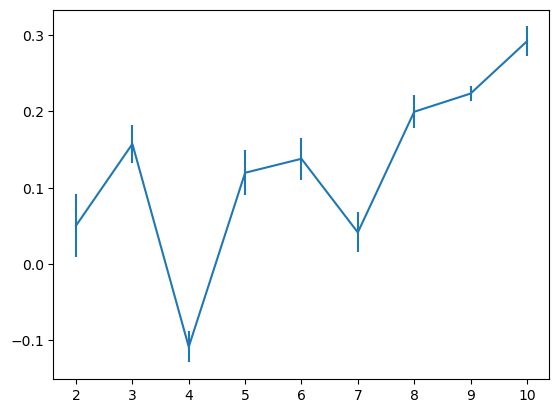

In [33]:
plt.errorbar(np.arange(2,11), gap_values[1:, 0], yerr=gap_values[1:, 1])


In [ ]:

X = era5_hannachi
hc = AgglomerativeClustering(n_clusters=3,
                             linkage='complete',
                             compute_distances=True).fit(X)
hc_label = hc.labels_

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, n_init='auto', random_state=42).fit(X)
kmeans_label = kmeans.labels_

In [ ]:
era5_hannachi['hc'] = hc_label
era5_hannachi['kmeans'] = kmeans_label
# compare label with mw, c/d, s/d
corr = era5_hannachi.corr()
corr[['kmeans', 'hc']].style.background_gradient(vmin=-1, vmax=1, cmap='RdBu')

In [ ]:
print(era5_hannachi.shape)
print("Label distribution by hierarchical clustering: ")
print('0 : ', era5_hannachi[era5_hannachi.hc == 0].shape) # 74
print('1 : ', era5_hannachi[era5_hannachi.hc == 1].shape) # 403
print('2 : ', era5_hannachi[era5_hannachi.hc == 2].shape) # 4624

print("Label distribution by kmeans clustering: ")
print('0 : ', era5_hannachi[era5_hannachi.kmeans == 0].shape) # 74
print('1 : ', era5_hannachi[era5_hannachi.kmeans == 1].shape) # 403
print('2 : ', era5_hannachi[era5_hannachi.kmeans == 2].shape) # 4624
print('3: ', era5_hannachi[era5_hannachi.kmeans==3].shape)

### Results from Hannachi et al.

| AR and Latc of vortex/AR, Lat, filtered vortex area | D  | U  | S  | Total |
|-----------------------------------------------------|----|----|----|-------|
| D                                                   | 7  |  3 | 0  | 10    |
| U                                                   | 4  | 80 | 2  | 86    |
| S                                                   | 1  | 0  | 3  | 4     |
| Total                                               | 12 | 83 | 5  | 100   |

### Results with Agglomorative Clustering:

| Label | Absolut | Perc (%) | Comment                                                                                                      |
|-------|---------|----------|--------------------------------------------------------------------------------------------------------------|
| 0     | 74      | 1,5      | Probably S<br/>Remains the same when removing other features<br/>74 when only area, latcent and ar were used |
| 1     | 403     | 8        | Probably D  <br/> Varies wildly when features removed                                                        |
| 2     | 4624    | 90,6     | Probably U  <br/>Varies wildly when features removed                                                         |
| Total | 5101    | 100      | --                                                                                                           |

Influence of different linkages:
- complete: used by Hannachi, dendogram does not indicate 3 clusters
- ward: appears similar to kmeans in distribution
- single: makes very weird Cluster with distribution 70, 4, 5027; indicates 3 Clusters
- average: makes also weird Cluster with distribution 70, 23, 5008; indicates 3 Clusters

### Results with kmeans Clustering:

| Label | Absolut | Perc (%)   | Comment                                                                                                      |
|-------|---------|------------|--------------------------------------------------------------------------------------------------------------|
| 0     | 2000    | 39,25      | Maybe D  <br/> Varies wildly, depending on features and random seed                                          |
| 1     | 79      | 1,5        | Probably S<br/>Remains the same when removing other features<br/>74 when only area, latcent and ar were used |
| 2     | 3022    | 59,25      | Maybe U  <br/>Varies wildly, just as D                                                                       |
| Total | 5101    | 100        | --                                                                                                           

#### Evaluation
S and U are underrepresented. Different measures?
Go for troubleshooting:
- Outliers? (~75?)
- Can I - based on my available data - differentiate between S, U, D?
- Data differences (s. previous part)
- Description of found cluster matching with Hannachi/general what are they?

Hierarchical cluster depends severly on **area**

In [ ]:
# Dendrogram
arctic.plot.plot_dendrogram(hc, truncate_mode='level', p=3, savefig='output/hc.png')

# Biplot
pc=5
#arctic.compute_pca(era5_hannachi, comp=pc, plot_type='3D', savefig='output/pca_era5_3D.png', n_arrows=2)
#arctic.compute_pca(era5_hannachi, comp=pc, plot_type='2D', n_arrows=2, savefig='output/pca_era5_2D.png')
# note "label" excluded from pca due to duplication of data.
era5_hannachi['label'] = era5_hannachi['hc']
arctic.compute_pca(era5_hannachi, comp=pc, plot_type='3D', savefig='output/pca_era5_hc_3D.png')
arctic.compute_pca(era5_hannachi, comp=pc, plot_type='2D', savefig='output/pca_era5_hc_2D.png')
#era5_hannachi['label'] = era5_hannachi['kmeans']
#arctic.compute_pca(era5_hannachi, comp=pc, plot_type='3D', savefig='output/pca_era5_kmeans_3D.png')
#arctic.compute_pca(era5_hannachi, comp=pc, plot_type='2D', savefig='output/pca_era5_kmeans_2D.png')

# Radar chart
def own_agg(x):
    return x.quantile(0.75)
arctic.plot.plot_radar(era5_hannachi, label='kmeans')
arctic.plot.plot_radar(era5_hannachi, agg_func=own_agg)

# Violinplot
arctic.plot_violin(era5_hannachi)

In [ ]:
# check time integrity of clustering
print("Distribution cluster: ", era5_hannachi.hc.value_counts())
print("Distribution form: ", era5_hannachi.form.value_counts())
era5_hannachi.groupby(['year', 'hc']).count()['label']

In [ ]:
era5_hannachi.groupby(['form', 'hc']).count()['label']